In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from fuzzywuzzy import fuzz

D:\Yash_folder\learning\hands_on\GitHub\recommender_systems\.venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# read data
df_movies = pd.read_csv('../data/movie.csv')

In [3]:
df_movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_movies.shape

(9742, 3)

In [5]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

### Cleanup title

In [6]:
# extract title
def extract_title(title):
    year = title[len(title)-5:len(title)-1]
    
    if year.isnumeric():
        title_no_year=title[:len(title)-7]
        return title_no_year
    else:
        return title

# extract year from title
def extract_year(title):
    year = title[len(title)-5:len(title)-1]
    
    if year.isnumeric():
        return int(year)
    else:
        return np.nan

In [7]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
df_movies['title'] = df_movies['title'].apply(lambda x:x.strip())
df_movies['title_only'] = df_movies['title'].apply(extract_title)
df_movies['year'] = df_movies['title'].apply(extract_year)

In [9]:
df_movies.dtypes

movieId         int64
title          object
genres         object
title_only     object
year          float64
dtype: object

In [10]:
df_movies.isnull().sum()

movieId        0
title          0
genres         0
title_only     0
year          12
dtype: int64

In [11]:
df_movies[df_movies['year'].isnull()]

,movieId,title,genres,title_only,year
6059,40697,Babylon 5,Sci-Fi,Babylon 5,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,Ready Player One,NaN
9091,143410,Hyena Road,(no genres listed),Hyena Road,NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),The Adventures of Sherlock Holmes and Doctor W...,NaN
9179,149334,Nocturnal Animals,Drama|Thriller,Nocturnal Animals,NaN
9259,156605,Paterson,(no genres listed),Paterson,NaN
9367,162414,Moonlight,Drama,Moonlight,NaN
9448,167570,The OA,(no genres listed),The OA,NaN
9514,171495,Cosmos,(no genres listed),Cosmos,NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),Maria Bamford: Old Baby,NaN


### Explore Genres

In [12]:
r,_ = df_movies[df_movies['genres']=='(no genres listed)'].shape 
print('The number of movies which do not have info about genres:',r)

The number of movies which do not have info about genres: 34


In [13]:
df_movies.head()

,movieId,title,genres,title_only,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995.0
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995.0


In [14]:
# map missing genres to "Other"
df_movies['genres'] = df_movies['genres'].replace('(no genres listed)', 'Other')

# some clean up
# df_movies['genres'] = df_movies['genres'].str.replace('|',' ')

In [15]:
counts = Counter()

# get genres counts
for genres in df_movies['genres']:
    for g in genres.split('|'):
        counts[g] += 1
counts

Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         'Other': 34})

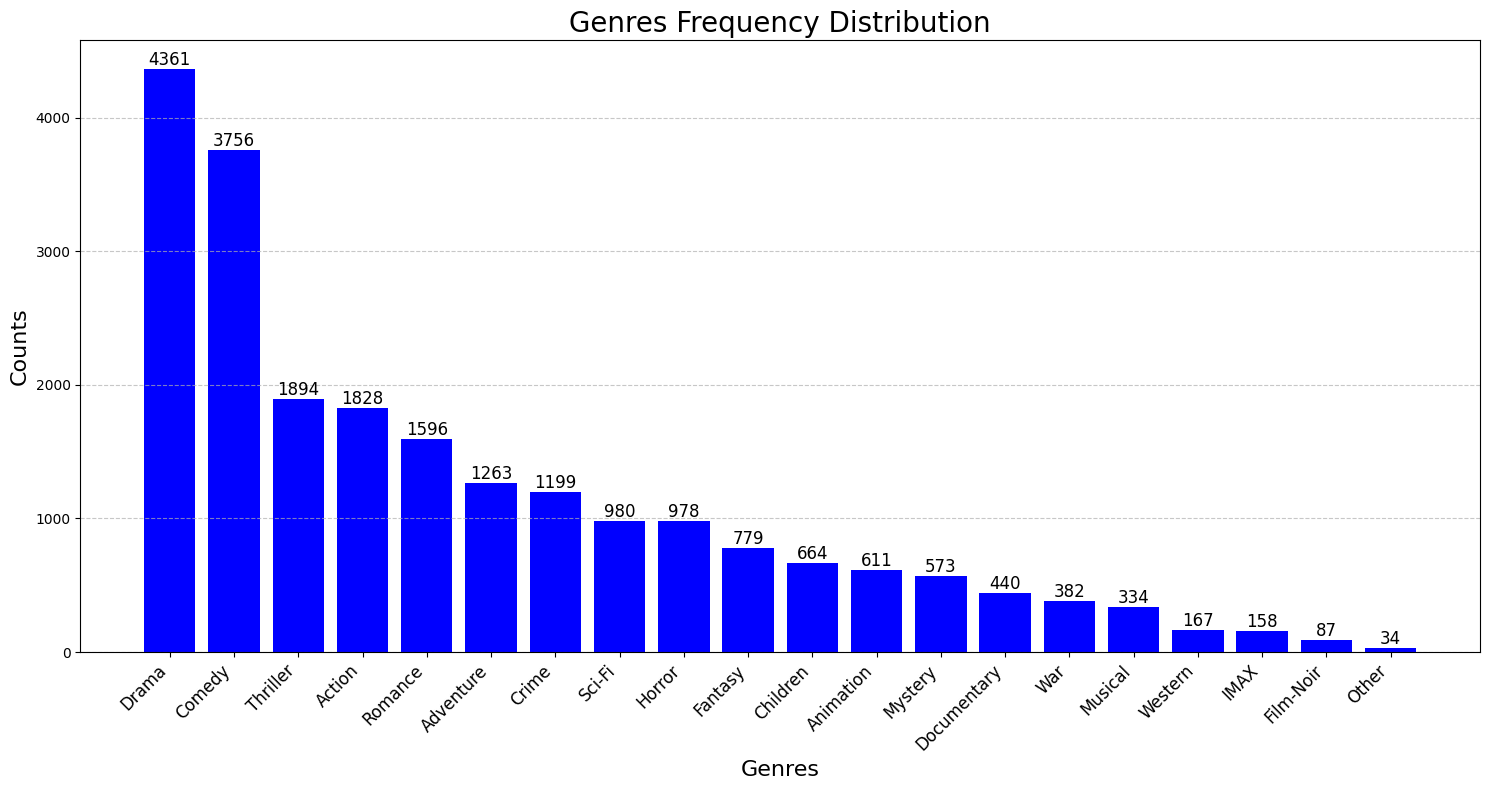

In [16]:
# plot it
plt.figure(figsize=(15,8))
sorted_counts = dict(sorted(counts.items(), key = lambda x: x[1], reverse=True))
bars = plt.bar(list(sorted_counts.keys()),sorted_counts.values(),color='b')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title('Genres Frequency Distribution', fontsize=20)
plt.xlabel('Genres', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optionally, add the count label on top of each bar 
for bar in bars: 
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, # position the text above the bar 
             round(yval, 2), ha='center', va='bottom', fontsize=12) 
plt.tight_layout()
plt.show()

### TF-IDF

In [17]:
df_movies['genres'] = df_movies['genres'].str.replace('Sci-fi','Scifi')
df_movies['genres'] = df_movies['genres'].str.replace('Film-Noir','Noir')

In [18]:
tfidf_vector = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vector.fit_transform(df_movies['genres'])

In [19]:
tfidf_vector

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,analyzer,'word'
,stop_words,'english'
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [20]:
print(list(enumerate(tfidf_vector.get_feature_names_out())))

[(0, 'action'), (1, 'adventure'), (2, 'animation'), (3, 'children'), (4, 'comedy'), (5, 'crime'), (6, 'documentary'), (7, 'drama'), (8, 'fantasy'), (9, 'fi'), (10, 'horror'), (11, 'imax'), (12, 'musical'), (13, 'mystery'), (14, 'noir'), (15, 'romance'), (16, 'sci'), (17, 'thriller'), (18, 'war'), (19, 'western')]


In [21]:
matrix_features = [item[1] for item in sorted(list(enumerate(tfidf_vector.get_feature_names_out())), key=lambda x: x[0], reverse=False)]
matrix_features

['action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'fi',
 'horror',
 'imax',
 'musical',
 'mystery',
 'noir',
 'romance',
 'sci',
 'thriller',
 'war',
 'western']

In [22]:
df_tfidf = pd.DataFrame(tfidf_matrix.todense(), columns=matrix_features)

In [23]:
df_tfidf.head()

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,horror,imax,musical,mystery,noir,romance,sci,thriller,war,western
0,0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.000000,0.482990,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.512361,0.000000,0.620525,0.000000,0.0,0.0,0.000000,0.593662,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.821009,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.505015,0.0,0.0,0.466405,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.726241,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [24]:
df_tfidf_merged = df_movies[['movieId', 'title']].merge(df_tfidf, how='left', left_index=True, right_index=True)
df_tfidf_merged.head()

,movieId,title,action,adventure,animation,children,comedy,crime,documentary,drama,...,horror,imax,musical,mystery,noir,romance,sci,thriller,war,western
0,1,Toy Story (1995),0.0,0.416846,0.516225,0.504845,0.267586,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),0.0,0.512361,0.000000,0.620525,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),0.0,0.000000,0.000000,0.000000,0.570915,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.821009,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),0.0,0.000000,0.000000,0.000000,0.505015,0.0,0.0,0.466405,...,0.0,0.0,0.0,0.0,0.0,0.726241,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [25]:
tfidf_matrix.shape

(9742, 20)

In [26]:
# get cosine similarity
sim_matrix=linear_kernel(tfidf_matrix,tfidf_matrix)
print(sim_matrix)

[[1.         0.81357774 0.15276924 ... 0.         0.4210373  0.26758648]
 [0.81357774 1.         0.         ... 0.         0.         0.        ]
 [0.15276924 0.         1.         ... 0.         0.         0.57091541]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.4210373  0.         0.         ... 0.         1.         0.        ]
 [0.26758648 0.         0.57091541 ... 0.         0.         1.        ]]


In [27]:
len(sim_matrix), len(sim_matrix[0])

(9742, 9742)

### Recommendation Engine

In [28]:
def get_title_year_from_index(index):
    return df_movies[df_movies.index==index]['year'].values[0]

def get_index_from_title(title):
    return df_movies[df_movies.title==title].index.values[0]

In [29]:
def matching_score(a,b):
    return fuzz.ratio(a,b)

In [30]:
def get_title_from_index(index):
    return df_movies[df_movies.index==index]['title'].values[0]

In [31]:
def find_closest_title(title):
    leven_scores = list(enumerate(df_movies['title_only'].apply(matching_score, b=title)))
    sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
    closest_title = get_title_from_index(sorted_leven_scores[0][0])
    distance_score = sorted_leven_scores[0][1]
    return closest_title, distance_score

In [32]:
# Example of fuzz to check string similarity
a = "Matrix part 1"
b = "Matrix part 2"
score1 = fuzz.ratio(a, b)

a = "Matrix"
b = "Jungle"
score2 = fuzz.ratio(a, b)

score1, score2

(92, 0)

### Get recommendation

In [33]:
def contents_based_recommender(movie_user_likes, how_many):
    closest_title, distance_score = find_closest_title(movie_user_likes)
    movie_index = get_index_from_title(closest_title)
    movie_list = list(enumerate(sim_matrix[int(movie_index)]))
    if distance_score == 100:
        similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True))) # remove the typed movie itself
    else:
        similar_movies = list(sorted(movie_list,key=lambda x:x[1], reverse=True))
    
    print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')

    temp_df = pd.DataFrame(similar_movies[:how_many], columns=['Title', 'Similarity_score'])
    temp_df['Title'] = temp_df['Title'].apply(lambda x: get_title_from_index(x))
    display(temp_df)
    

In [34]:
contents_based_recommender('Toy Story',15)

Here's the list of movies similar to Toy Story (1995).



,Title,Similarity_score
0,Antz (1998),1.000000
1,Toy Story 2 (1999),1.000000
2,"Adventures of Rocky and Bullwinkle, The (2000)",1.000000
3,"Emperor's New Groove, The (2000)",1.000000
4,"Monsters, Inc. (2001)",1.000000
5,"Wild, The (2006)",1.000000
6,Shrek the Third (2007),1.000000
7,"Tale of Despereaux, The (2008)",1.000000
8,Asterix and the Vikings (Astérix et les Viking...,1.000000
9,Turbo (2013),1.000000
